In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
import scipy.fftpack
from kymatio import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
%matplotlib inline
import scipy.stats as stats


In [2]:
fig = plt.figure()
fw = fig.get_figwidth()
fh = fig.get_figheight()

<Figure size 432x288 with 0 Axes>

In [63]:
N = 10 
pix_num = 2**N
pix_size  = 0.5 # size of a pixel in arcminutes

<ipython-input-64-c3e19f6c6e62>:6: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)


Text(0, 0.5, '$ln(D_l)$')

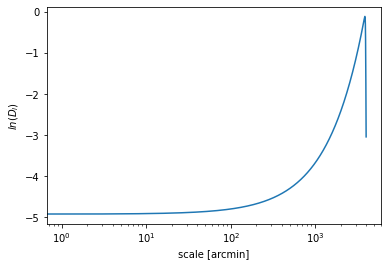

In [64]:
lmax=4000
ell=np.arange(0,lmax+1)

dl=1/(np.exp((60-ell)/20)+np.exp((ell-60)/800))

ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)
#ellsc=ellsc[::-1]

fdl=dl[::-1]
plt.plot (ell, np.log(fdl))
#plt.plot(ellsc,np.log(dl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

In [65]:

X_width = pix_num*pix_size/60.  # horizontal map width in degrees
Y_width = pix_num*pix_size/60.  # vertical map width in degrees

In [66]:



seed = 589
np.random.seed(seed)

def make_map(pix_num, pix_size, ell, Dl): 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    # convert Dl to Cl
    Cl = Dl * 2 * np.pi / (ell*(ell+1.))
    Cl[0] = 0. 
    Cl[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(pix_num)
    inds  = (np.arange(pix_num)+.5 - pix_num/2.) /(pix_num-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    Cl_expanded = np.zeros(int(ell2d.max())+1)
    
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    Cl_expanded[0:(Cl.size)] = Cl # fill in the Cls until the max of the Cl vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CL2d = Cl_expanded[ell2d.astype(int)]         
    
    # now make a realization of the given power spectrum in real space
    random_array = np.random.normal(0,1,(pix_num, pix_num))
    FT_random_array = np.fft.fft2(random_array) # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CL2d) * FT_random_array
    # plt.imshow(np.real(FT_2d))
    
    # move back from ell space to real space
    map_ = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    map_ = map_/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    map_ = np.real(map_)

    ## return the map
    return(map_)
  ###############################

def Plot_Map(Map_to_Plot, X_width, Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(5, 5)
    im = plt.imshow(Map_to_Plot, interpolation=None, origin='lower',cmap=cm.YlOrBr)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
#     plt.ylabel('angle $[^\circ]$')
#     plt.xlabel('angle $[^\circ]$')
    
#     plt.savefig('cmbmap1.png',transparent=False)
    plt.show()
    
    return(0)
  ###############################

In [67]:

if max(ell)< lmax: 
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)




<ipython-input-66-2c3014d2f3c6>:7: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1.))


map mean: -0.28129210717496167 map rms: 1.681754340755765


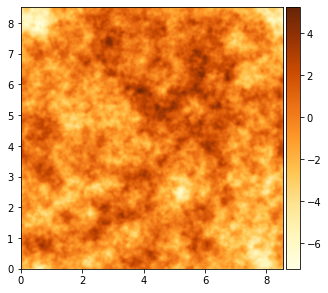

0

In [68]:
fmap = make_map(pix_num ,pix_size, ell, dl)
Plot_Map(fmap ,X_width, Y_width)

In [69]:
#### parameters for setting up the spectrum
delta_ell = 1
ell_max = lmax


/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


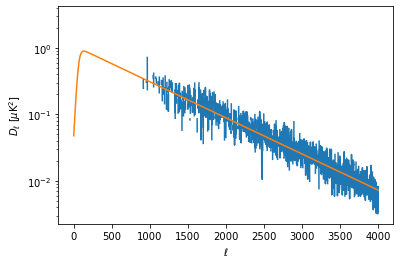

In [70]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(fmap,fmap,delta_ell,ell_max,pix_size,pix_num)
#print binned_ell
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,dl)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

map mean: 2.9074229122097868 map rms: 4.572410203239227


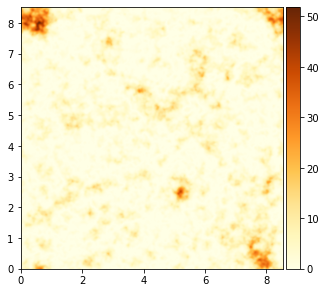

0

In [71]:
fmap_sqrt = fmap**2
Plot_Map(fmap_sqrt ,X_width, Y_width)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


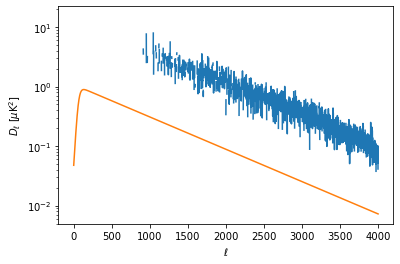

In [72]:
## make a power spectrum
binned_ell_sqrt, binned_spectrum_sqrt = calculate_2d_spectrum(fmap_sqrt,fmap_sqrt,delta_ell,ell_max,pix_size,pix_num)
#print binned_ell
dl_sqrt = binned_spectrum_sqrt* binned_ell_sqrt * (binned_ell_sqrt+1.)/2. / np.pi
plt.semilogy(binned_ell_sqrt,binned_spectrum_sqrt* binned_ell_sqrt * (binned_ell_sqrt+1.)/2. / np.pi)
plt.semilogy(ell,dl)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

In [118]:
binned_scale_sqrt = 21600/binned_ell_sqrt
binned_scale_sqrt
#fdl_sqrt = dl_sqrt[::-1]

<ipython-input-118-00b3f126d927>:1: RuntimeWarning: divide by zero encountered in true_divide
  binned_scale_sqrt = 21600/binned_ell_sqrt


Text(0, 0.5, '$ln(D_l)$')

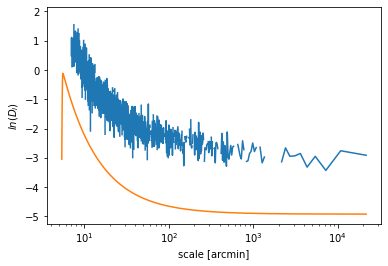

In [119]:
plt.plot(binned_scale_sqrt,np.log(fdl_sqrt))
plt.plot(ellsc,np.log(fdl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

In [120]:
gaus_map_sqrt = make_map (pix_num, pix_size, binned_ell_sqrt, binned_spectrum_sqrt)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


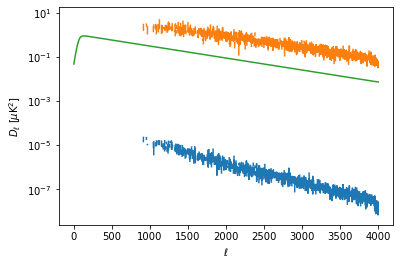

In [122]:
## make a power spectrum
binned_ell_sqrt_gaus, binned_spectrum_sqrt_gaus = calculate_2d_spectrum(gaus_map_sqrt, gaus_map_sqrt,delta_ell,ell_max,pix_size,pix_num)
#print binned_ell
dl_sqrt_gaus = binned_spectrum_sqrt_gaus* binned_ell_sqrt_gaus * (binned_ell_sqrt_gaus+1.)/2. / np.pi
plt.semilogy(binned_ell_sqrt_gaus, binned_spectrum_sqrt_gaus* binned_ell_sqrt_gaus * (binned_ell_sqrt_gaus+1.)/2. / np.pi)
plt.semilogy(binned_ell_sqrt, binned_spectrum_sqrt* binned_ell_sqrt * (binned_ell_sqrt+1.)/2. / np.pi)
plt.semilogy(ell,dl)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

map mean: 1.0759257743041074e-05 map rms: 0.000265782009503548


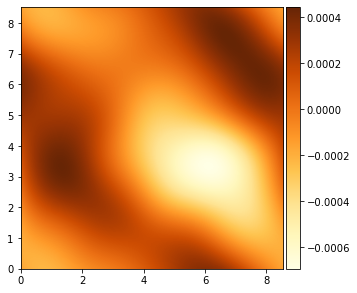

0

In [88]:
Plot_Map(gaus_map_sqrt, X_width, Y_width)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import healpy as hp
import time
import warnings
import scipy.fftpack

In [92]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #print ()
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    #print (arg.shape)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab

In [93]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

In [94]:
def comp_s1(image, morlet_arr, jmax, gaus_arr = None):
    
    s1_arr = np.zeros (jmax)
    i1_arr = []
    for j1 in range(jmax):
        
        #sigma1=0.8*2**j1
        #freq1=(3*np.pi)/(4.*2**j1)
        
        #mor1=morlet_2d(M, N, sigma1, freq1)
        #phi1=gabor_2d(M,N,sigma1,0)
        
        mor = morlet_arr[j1]
        mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))
        
        img_fft = np.fft.fft2(image)
        I1_fft = img_fft * mor_fft
        I1 = np.abs (np.fft.ifft2(I1_fft))
        
        
        if gaus_arr == None:
            S1 = I1
        else:
            phi = gaus_arr[j1]
            phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
            U1_fft = np.fft.fft2(I1)
            S1_fft = U1*phi_fft
            S1 = np.real(np.fft.ifft2(S1_fft))
        
        i1_arr.append(S1)
        s1_arr[j1] = np.mean(S1)
    
    return s1_arr , i1_arr

In [95]:
def comp_s2 (i1_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s2_arr = np.zeros ((jmax,jmax))
    i2_arr = []
    for j1 in range(jmax):
        i2_tmp = []
        i1 = i1_arr[j1]
        i1_fft = np.fft.fft2(i1)
        
        for j2 in range (jmax):
        
            mor = morlet_arr[j2]
            mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))

            
            I2_fft = i1_fft * mor_fft
            I2 = np.abs (np.fft.ifft2(I2_fft))


            if gaus_arr == None:
                S2 = I2
            else:
                phi = gaus_arr[j2]
                phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                U2_fft = np.fft.fft2(I2)
                S2_fft = I2*phi_fft
                S2 = np.abs(np.fft.ifft2(S2_fft))

            s2_arr[j1,j2] = np.mean(S2)
            i2_tmp.append(S2)
        i2_arr.append (i2_tmp)
    return s2_arr , i2_arr

In [96]:
def comp_s3 (i2_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s3_arr = np.zeros ((jmax,jmax,jmax))
    #i3_arr = []
    for j1 in range(jmax):
        for j2 in range (j1+1 ,jmax):
            #i3_tmp = []
            i2 = i2_arr[j1][j2]
            i2_fft = np.fft.fft2(i2)
        
            for j3 in range (jmax):
        
                mor = morlet_arr[j3]
                mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))


                I3_fft = i2_fft * mor_fft
                I3 = np.abs (np.fft.ifft2(I3_fft))


                if gaus_arr == None:
                    S3 = I3
                else:
                    phi = gaus_arr[j3]
                    phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                    U3_fft = np.fft.fft2(I3)
                    S3_fft = I3*phi_fft
                    S3 = np.abs(np.fft.ifft2(S3_fft))

                s3_arr[j1,j2,j3] = np.mean(S3)
                #i3_tmp.append(S2)
        #i2_arr.append (i2_tmp)
    return s3_arr #, i2_arr

In [97]:
#maximum scale of the picture is chosen so that 2**jmax < min (x_dim , y_dim)
jmax = int (np.floor(np.log (pix_num)/np.log(2))+1)
print(jmax)

11


In [99]:
# making a list of morlet maps

morlet_arr = []
for j in range (jmax):
    sigma=0.8*2**j
    freq=(3*np.pi)/(4.*2**j)
    mor = morlet_2d (pix_num, pix_num, sigma, freq)
    morlet_arr.append(mor)
    
    

In [100]:
s1 , i1 = comp_s1(fmap_sqrt, morlet_arr, jmax)

In [101]:
s2 , i2 = comp_s2(i1, morlet_arr, jmax)

IndexError: index 3 is out of bounds for axis 0 with size 3

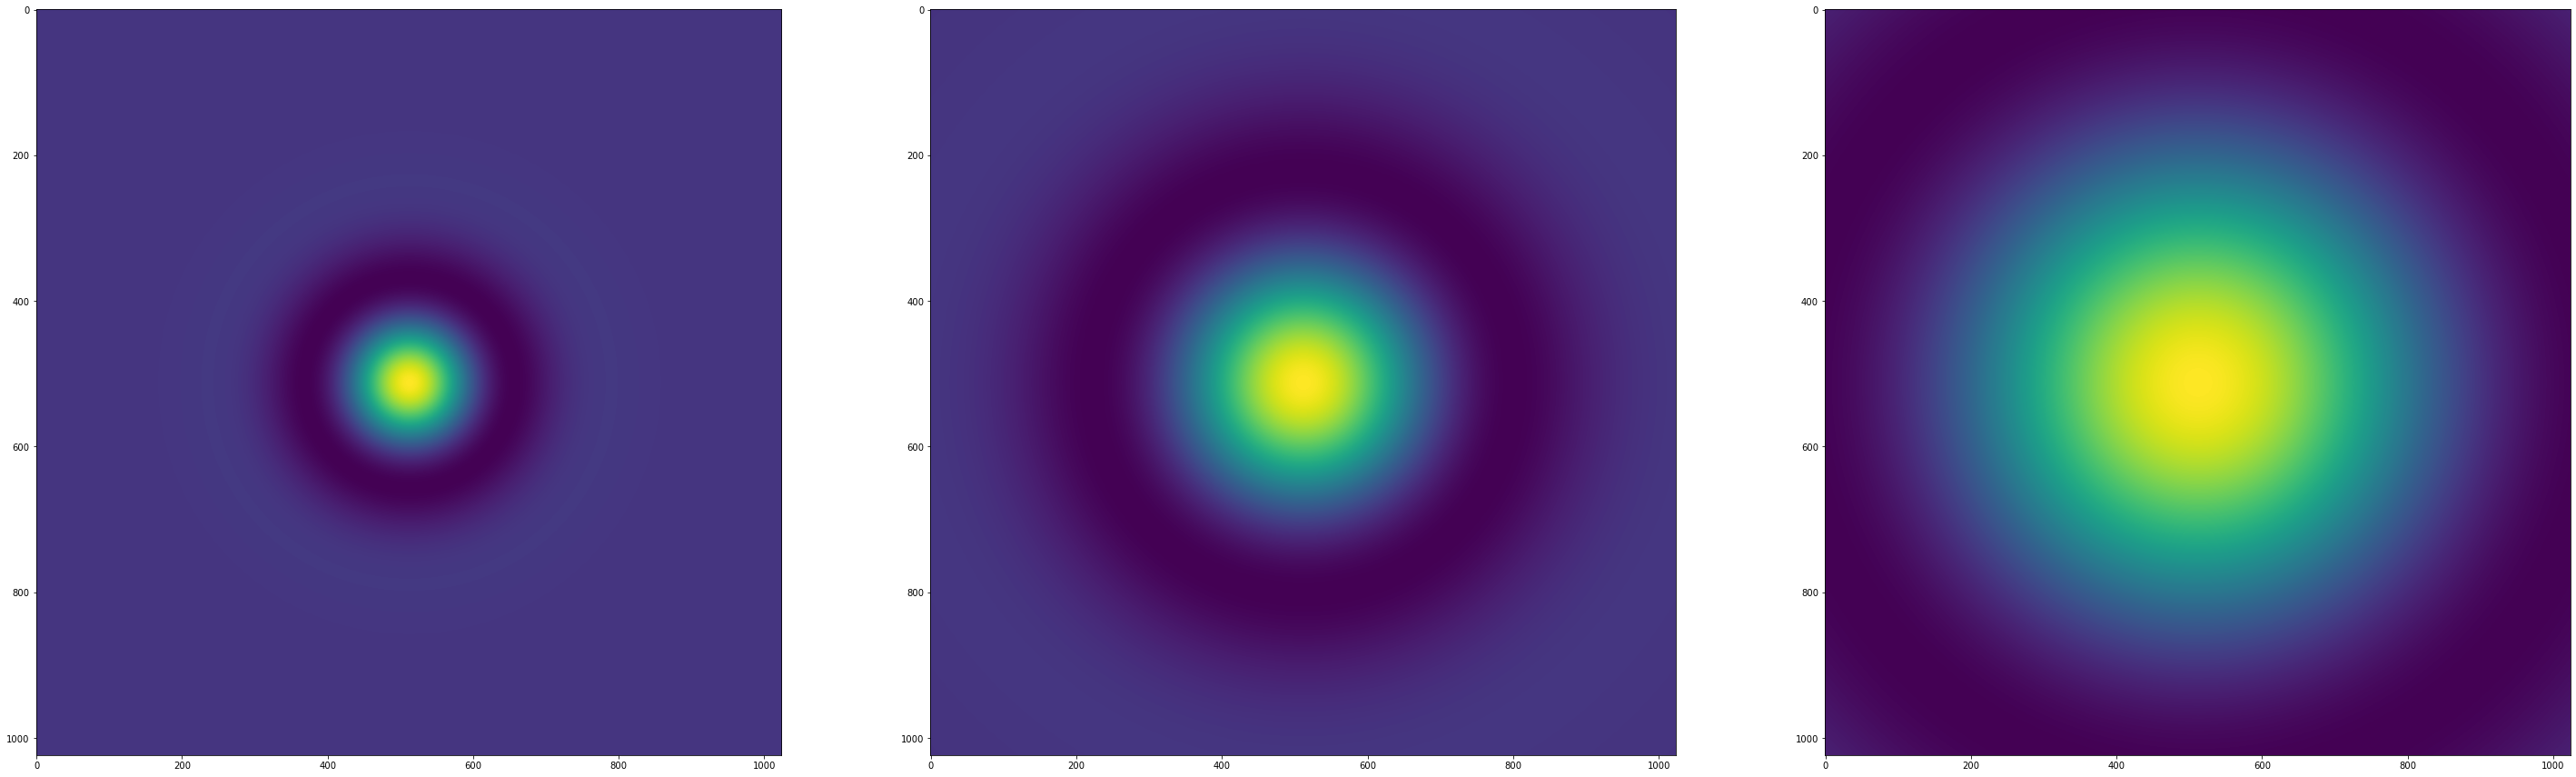

In [102]:
fig , ax = plt.subplots(1, 3, figsize = (50,50))
for i in range (7,jmax):
    ax[i-7].imshow(np.real(morlet_arr[i]))
#plt.show()

#plt.imshow (np.real(morlet_arr[7]))

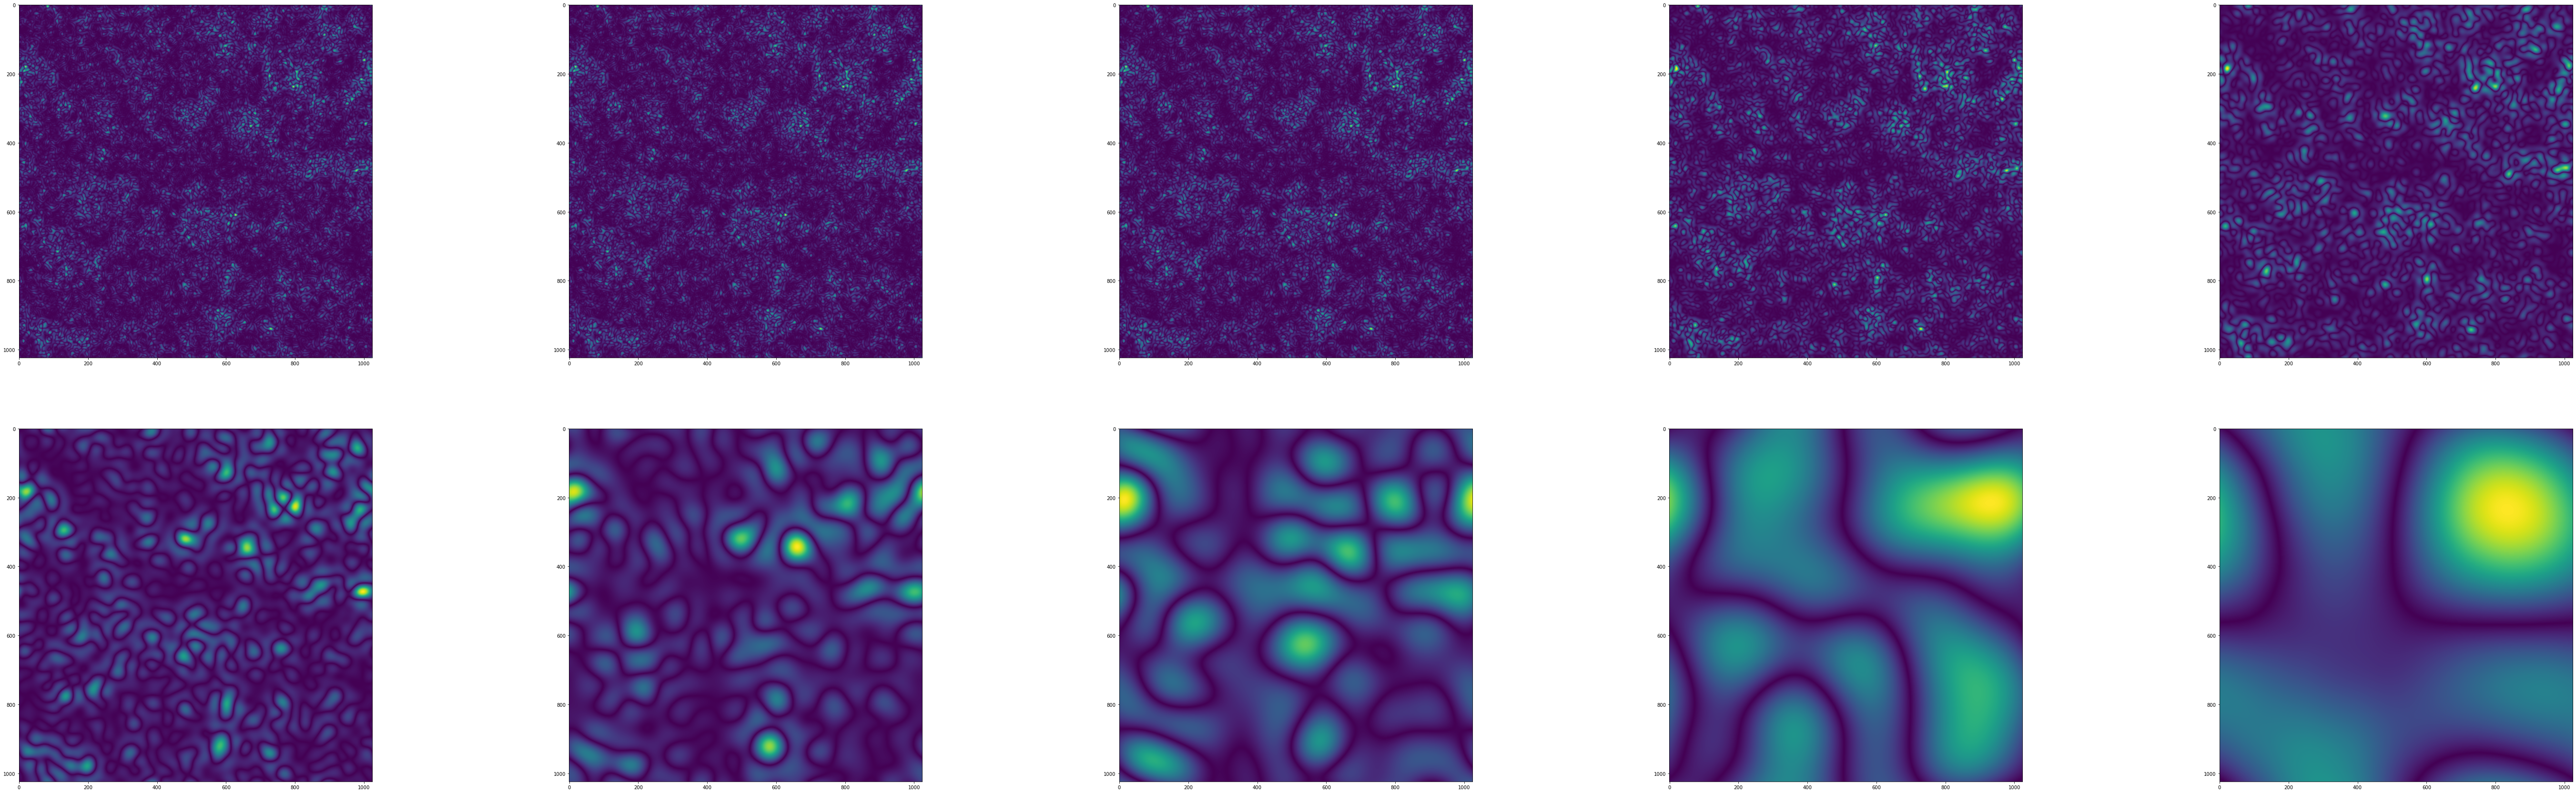

In [103]:
fig , ax = plt.subplots (2, 5 , figsize = (100,30))
for i in range (5):
    ax[0,i].imshow(i1[i])

for i in range (5,10):
    ax[1,i-5].imshow(i1[i])

In [104]:
jarray = np.arange (jmax)
scale = 2**jarray

Text(0, 0.5, 'S1')

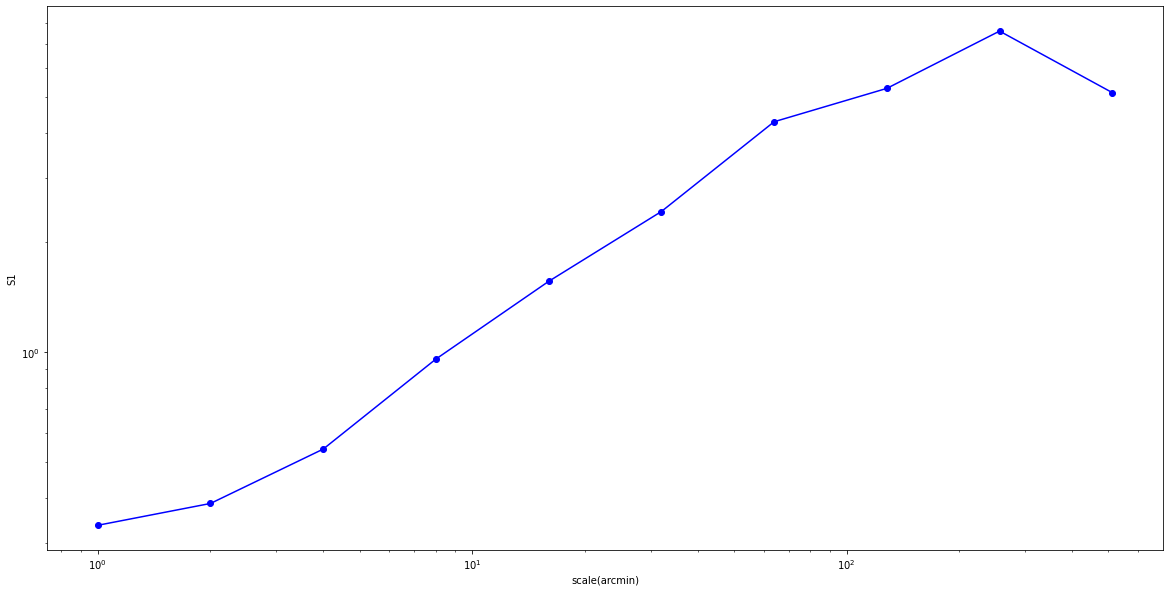

In [21]:
plt.figure(figsize=(20,10))
plt.loglog (scale,s1,'o-',color="blue")

plt.xlabel("scale(arcmin)")
plt.ylabel("S1") 
#plt.legend (["non-Gaussian", "Gaussian"])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


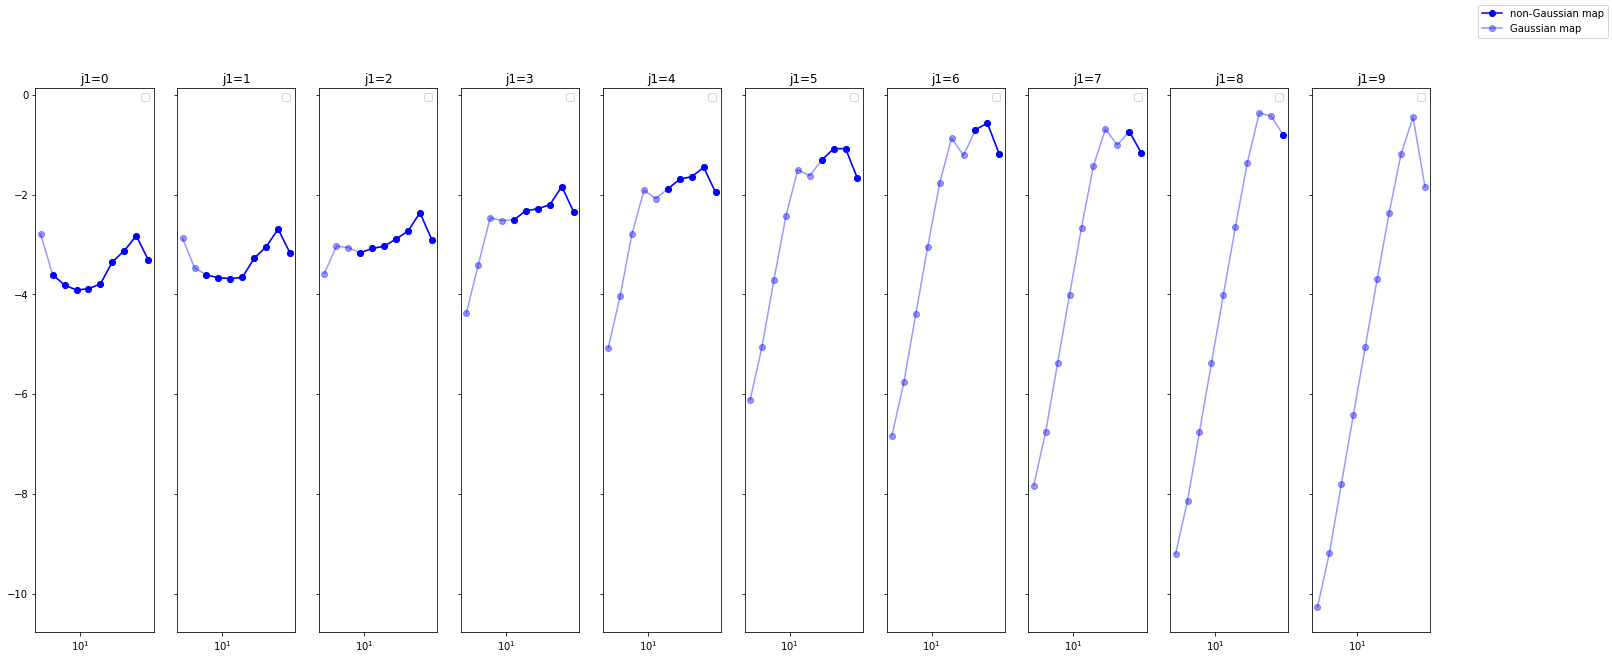

In [22]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale[j+1:],np.log(s2[j,j+1:]),'o-' , alpha =1 , color = "blue")
    #ax[j].plot (scale_0256[j+1:],np.log(s2_cubed_Gaus_0256[j,j+1:]),'o-' , alpha = 1 , color = "red")
    ax[j].plot (scale,np.log(s2[j,:]),'o-' , alpha = 0.4 , color = "blue")
    #ax[j].plot (scale_0256,np.log(s2_cubed_Gaus_0256[j,:]),'o-' , alpha =0.4 , color = "red")
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
fig.legend(['non-Gaussian map' ,'Gaussian map'])

In [540]:
# surface of the image
mu0 = x_dim*y_dim

In [541]:
map_delta = np.zeros((x_dim, y_dim))
map_delta[int(x_dim/2+1),int(y_dim/2+1)] = mu0

In [542]:
s1_delta , i1_delta = comp_s1(map_delta, morlet_arr, jmax)
s2_delta , i2_delta = comp_s2(i1_delta, morlet_arr, jmax)

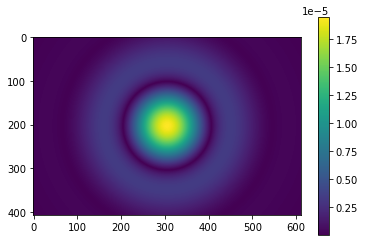

In [474]:
plt.imshow(np.abs(np.real(morlet_arr[7])))
plt.colorbar()

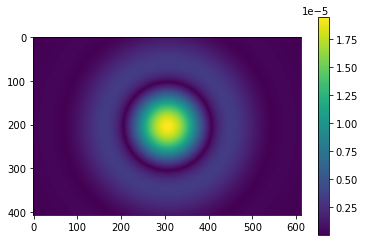

In [475]:
plt.imshow (i1_delta[7]/mu0)
plt.colorbar()

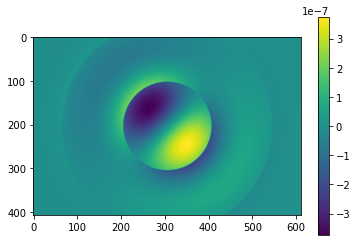

In [476]:
plt.imshow(i1_delta[7]/mu0-np.abs (np.real(morlet_arr[7])))
plt.colorbar()

In [543]:
s1_normalized = s1/s1_delta
s2_normalized = s2/s2_delta

In [544]:
I0sqrt = np.mean(img**2)
I0sqrt

49498.36068020833

In [545]:
s1_normalized

array([ 0.46900428,  0.69545581,  1.01772697,  1.78384135,  2.90941147,
        4.52196394,  7.96671209,  9.83370838, 14.96509544, 18.34081554])

In [546]:
s0_normalized = np.mean(img)
s0_normalized**2 

45437.137194929564

In [547]:
s2_sum = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum += s2_normalized[j1,j2]**2

In [550]:
RHS = s0_normalized**2 + np.sum(s1_normalized**2) + s2_sum #+s3_sum

In [3]:
(I0sqrt-RHS)/I0sqrt


NameError: name 'I0sqrt' is not defined

In [552]:
(I0sqrt-s0_normalized**2)/I0sqrt

0.08204763611297991

In [553]:
np.sum(s1_normalized**1)

62.50373526978234

In [554]:
s2_sum

81.52072464936106

In [555]:
s3 = comp_s3(i2, morlet_arr, jmax)

In [556]:
s3_delta = comp_s3(i2_delta, morlet_arr, jmax)

In [557]:
s3_normalized = s3/s3_delta 

<ipython-input-557-ee35e1ebd7a6>:1: RuntimeWarning: invalid value encountered in true_divide
  s3_normalized = s3/s3_delta


In [558]:
s3_sum = 0
for j1 in range (jmax):
    for j2 in range (j1+1, jmax):
        for j3 in range (j2+1, jmax):
            s3_sum += s3_normalized[j1,j2,j3]**2

In [2]:
s3_sum

NameError: name 's3_sum' is not defined

In [1]:
I1sqrt = np.mean(i1[1]**2)
I1sqrt

NameError: name 'np' is not defined

In [579]:
RHS2 = s1_normalized[2]**2 + np.sum(s2_normalized[2,3:]**2)

In [582]:
(I1sqrt - RHS2)/I1sqrt

0.022155309811814468